In [17]:
import matplotlib.pyplot as plt
import random as rnd
import pandas as pd
import os
import plotly.express as px
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [18]:
# organiza os resultados em dataframe. não mexer!

# colunas
# visit_id,period,selected_product,predicted,algorithm,model_type,model_version,cycle_duration,ab_duration_pct,masking


def filter_df(df, algorithm, masking, cycle_duration, ab_duration_pct, alternate_model_pct):

	return df[(df['algorithm'] == algorithm) & (df['masking'] == masking) & (df['cycle_duration'] == cycle_duration) & (df['ab_duration_pct'] == ab_duration_pct) & (df['alternate_model_pct'] == alternate_model_pct)]


SELECTED_PRODUCT = 'selected_product'
PREDICTED = 'predicted'

summary_df = pd.DataFrame()
results_df = pd.read_csv("data/results.csv")

algorithms = results_df['algorithm'].unique()
algorithms.sort()

masking_pcts = results_df['masking'].unique()
masking_pcts.sort()

cycle_durations = results_df['cycle_duration'].unique()
cycle_durations.sort()

ab_duration_pcts = results_df['ab_duration_pct'].unique()
ab_duration_pcts.sort()

alternate_model_pcts = results_df['alternate_model_pct'].unique()
alternate_model_pcts.sort()


hits = [1 if r else 0 for r in results_df['selected_product'] == results_df['predicted']]
results_df['hit'] = hits

# computa os hit ratios
hr_df = results_df.groupby(['algorithm', 'masking', 'cycle_duration', 'ab_duration_pct', 'alternate_model_pct']).apply(lambda x: x['hit'].sum()/len(x)).reset_index(name='hit_ratio')
hr_df['ab_test_num_items'] = hr_df['cycle_duration'] * hr_df['ab_duration_pct'] * hr_df['alternate_model_pct']
hr_df['ab_test_num_items'] = hr_df['ab_test_num_items'].astype(int)


ab_test_num_items = hr_df['ab_test_num_items'].unique()
ab_test_num_items.sort()


hr_df

pass

In [19]:
hr_df
pass

In [20]:
# BIBLIOTECAS ... não mexer!
algorithms_names = {'naive_bayes': "Naive Bayes", 'random_forest': 'Random Forest', 'neural_network': 'Rede Neural', 'logistic_regression': 'Regressão Logística'}

def multi_bar(row_items, column_items, labels, values_matrix, graphs_titles=None, main_title=None, fn_format_label=None, size_inches_w = 12, size_inches_h = 12):

	sharey = True
	sharex = True	

	fig, axs = plt.subplots(len(row_items), len(column_items), sharex=sharex, sharey=sharey)
	fig.set_size_inches(size_inches_h, size_inches_w)

	for row_num in range(len(row_items)):

		for col_num in range(len(column_items)):

			i = (row_num * len(column_items)) + col_num
			values = values_matrix[i]
			
			# trainning_freq = trainning_freqs[i]
			# masking_pct = masking_pcts[j]

			# tmp_df = results_df[(results_df['masking_pct'] == masking_pct) & (results_df['trainning_freq'] == trainning_freq)]
			# tmp_df = tmp_df.sort_values(by=['algorithm'], ascending=[False])
			
			# marcando o valor máximo em verde
			bar_colors = []
			for k in range(len(values)):
				bar_colors.append('green' if values[k] == max(values) else 'silver')
			

			bars = axs[row_num, col_num].barh(labels, values, label=labels, color=bar_colors)

			
			if (fn_format_label): axs[row_num, col_num].bar_label(bars, fmt=fn_format_label) # , padding=-40)
			if (graphs_titles): axs[row_num, col_num].set_title(graphs_titles[i])

			
			# axs[j].legend(title='Algoritmo')


	if main_title: fig.suptitle("Acurácia por cenário")
	plt.show()


# for fmt see https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html
def multi_line(row_items, column_items, values_matrix_x, values_matrix_y, fmt='bo', graphs_titles=None, main_title=None, size_inches_w = 12, size_inches_h = 12):

	sharey = True
	sharex = True	

	fig, axs = plt.subplots(len(row_items), len(column_items), sharex=sharex, sharey=sharey)
	fig.set_size_inches(size_inches_h, size_inches_w)

	for row_num in range(len(row_items)):

		for col_num in range(len(column_items)):

			i = (row_num * len(column_items)) + col_num
			values_x = values_matrix_x[i]
			values_y = values_matrix_y[i]
			
			# trainning_freq = trainning_freqs[i]
			# masking_pct = masking_pcts[j]

			# tmp_df = results_df[(results_df['masking_pct'] == masking_pct) & (results_df['trainning_freq'] == trainning_freq)]
			# tmp_df = tmp_df.sort_values(by=['algorithm'], ascending=[False])
			
			# marcando o valor máximo em verde
			# line_colors = []
			#for k in range(len(values)):
			#	line_colors.append('green' if values[k] == max(values) else 'silver')
			

			# bars = axs[row_num, col_num].barh(labels, values, label=labels, color=line_colors)
			bars = axs[row_num, col_num].plot(values_x, values_y, fmt)

			
			# if (fn_format_label): axs[row_num, col_num].bar_label(bars, fmt=fn_format_label) # , padding=-40)
			if (graphs_titles): axs[row_num, col_num].set_title(graphs_titles[i])

			
			# axs[j].legend(title='Algoritmo')


	if main_title: fig.suptitle(main_title)
	plt.show()


def single_variable_per_algorithm_graph(variable_name, x_outer_label, y_outer_label, percentual_x: bool):

	target_df = hr_df.groupby(['algorithm', variable_name]).agg({'hit_ratio': ['min', 'max']})
	target_df = target_df.reset_index()

	plt.figure(dpi=600)

	num_rows = int((len(algorithms) + 1) / 2) 
	num_cols = 1 if len(algorithms) == 1 else 2

	fig, axs = plt.subplots(num_rows, num_cols, sharex=True, sharey=True, squeeze=False)
	c = 0

	plt.ylim(min(target_df[('hit_ratio', 'min')]) * 100 * 0.9, max(target_df[('hit_ratio', 'max')]) * 100* 1.1)

	# add a big axis, hide frame
	fig.add_subplot(111, frameon=False)
	# hide tick and tick label of the big axis
	plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
	plt.xlabel(x_outer_label, size=8)
	plt.ylabel(y_outer_label, size=8)


	for algorithm in algorithms:
		labels = [str(round(100*v)) for v in target_df[(target_df['algorithm'] == algorithm)][variable_name]] if percentual_x else [str(v) for v in target_df[(target_df['algorithm'] == algorithm)][variable_name]]
		v_min = target_df[(target_df['algorithm'] == algorithm)][('hit_ratio', 'min')]
		v_max = target_df[(target_df['algorithm'] == algorithm)][('hit_ratio', 'max')]

		v_min = np.multiply(v_min, 100)
		v_max = np.multiply(v_max, 100)	

	
		ax = axs[int(c / 2), c % 2]


		bar_colors = ['green' if v == max(v_max) else 'silver' for v in v_max]


		p = ax.bar(labels, v_max, color=bar_colors)
		# ax.bar_label(p, label_type='edge', fmt=lambda v: "{v:.2f}%".format(v=v), size=8)
		ax.bar_label(p, label_type='edge', fmt=lambda v: "{v:.2f}%".format(v=v).replace(".", ","), size=8)

		# p = ax.bar(labels, v_max, bottom=v_min)
		p = ax.bar(labels, v_min, color='white')
		ax.bar_label(p, label_type='edge', fmt=lambda v: "{v:.2f}%".format(v=v).replace(".", ","), padding=-10, size=8)
		# p = ax.bar(labels, np.subtract(v_max, v_min), bottom=v_min)

		c += 1

		ax.set_title(algorithms_names[algorithm], size=10)
		
		# ax.legend(loc="upper right")


	plt.tight_layout()
	plt.show()


<Figure size 3840x2880 with 0 Axes>

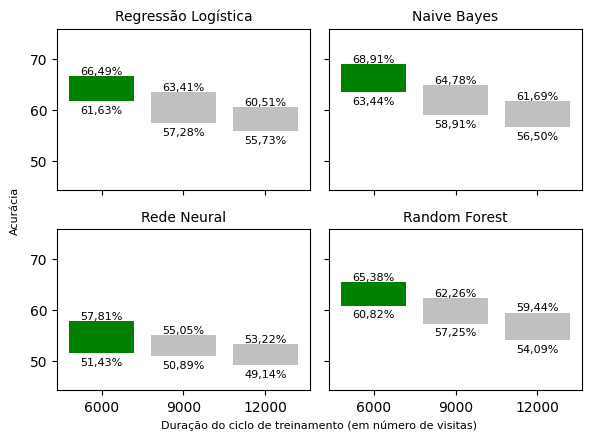

<Figure size 3840x2880 with 0 Axes>

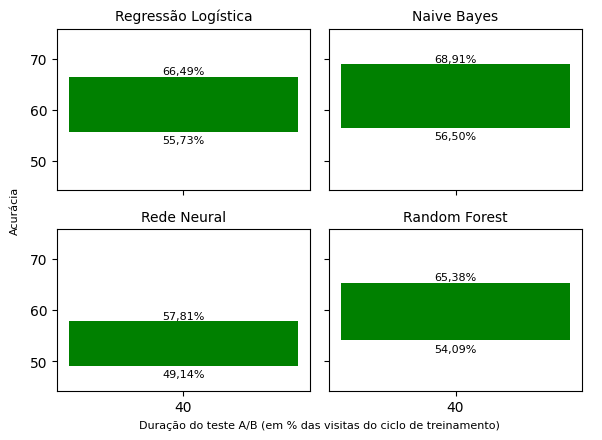

<Figure size 3840x2880 with 0 Axes>

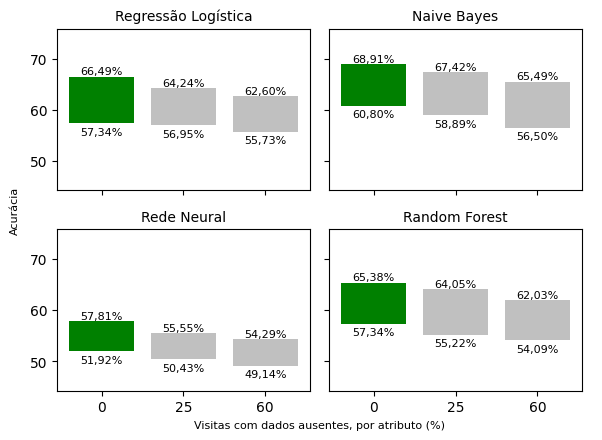

<Figure size 3840x2880 with 0 Axes>

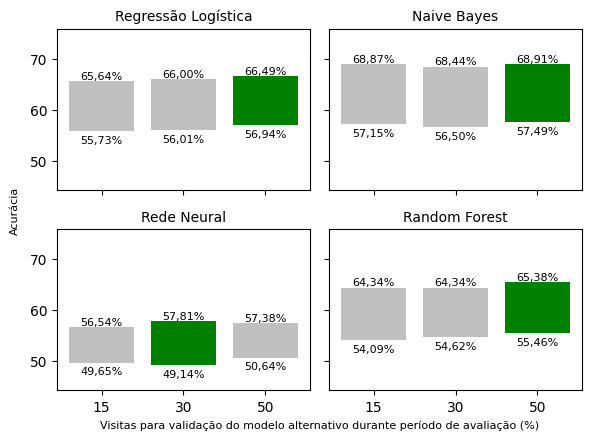

In [21]:
# Índices de acertos mínimos e máximos por tamanho do ciclo de testes



variable_name = 'cycle_duration'
x_outer_label = "Duração do ciclo de treinamento (em número de visitas)"
y_outer_label = "Acurácia"
percentual_x = False
single_variable_per_algorithm_graph(variable_name=variable_name, x_outer_label=x_outer_label, y_outer_label=y_outer_label, percentual_x=percentual_x)


variable_name = 'ab_duration_pct'
x_outer_label = "Duração do teste A/B (em % das visitas do ciclo de treinamento)"
y_outer_label = "Acurácia"
percentual_x = True
single_variable_per_algorithm_graph(variable_name=variable_name, x_outer_label=x_outer_label, y_outer_label=y_outer_label, percentual_x=percentual_x)


variable_name = 'masking'
x_outer_label = "Visitas com dados ausentes, por atributo (%)"
y_outer_label = "Acurácia"
percentual_x = False
single_variable_per_algorithm_graph(variable_name=variable_name, x_outer_label=x_outer_label, y_outer_label=y_outer_label, percentual_x=percentual_x)

variable_name = 'alternate_model_pct'
x_outer_label = "Visitas para validação do modelo alternativo durante período de avaliação (%)"
y_outer_label = "Acurácia"
percentual_x = True
single_variable_per_algorithm_graph(variable_name=variable_name, x_outer_label=x_outer_label, y_outer_label=y_outer_label, percentual_x=percentual_x)









<Figure size 3840x2880 with 0 Axes>

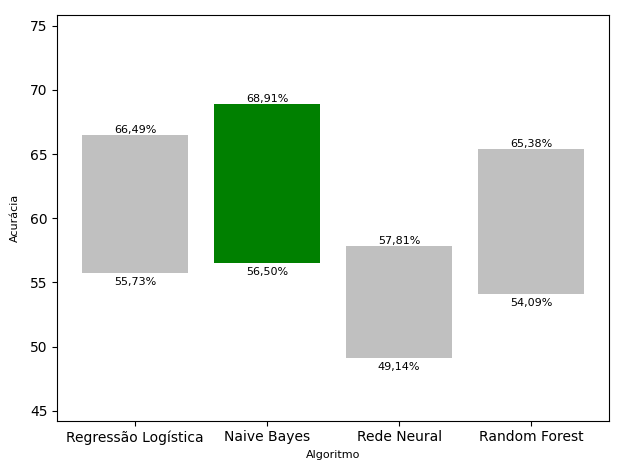

In [22]:
hr_df

algo_df = hr_df.groupby(['algorithm']).agg({'hit_ratio': ['min', 'max']})
algo_df.reset_index()


plt.figure(dpi=600)
fig, axs = plt.subplots(1, 1, sharex=True, sharey=True)
c = 0

plt.ylim(min(algo_df[('hit_ratio', 'min')]) * 100 * 0.9, max(algo_df[('hit_ratio', 'max')]) * 100* 1.1)

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Algoritmo', size=8)
plt.ylabel('Acurácia', size=8)


labels = [algorithms_names[algorithm] for algorithm in algorithms]
v_min = algo_df[('hit_ratio', 'min')]
v_max = algo_df[('hit_ratio', 'max')]

v_min = np.multiply(v_min, 100)
v_max = np.multiply(v_max, 100)	

ax = axs # [0, 0]

bar_colors = ['green' if v == max(v_max) else 'silver' for v in v_max]


p = ax.bar(labels, v_max, color=bar_colors)
# ax.bar_label(p, label_type='edge', fmt=lambda v: "{v:.2f}%".format(v=v), size=8)
ax.bar_label(p, label_type='edge', fmt=lambda v: "{v:.2f}%".format(v=v).replace(".", ","), size=8)

# p = ax.bar(labels, v_max, bottom=v_min)
p = ax.bar(labels, v_min, color='white')
ax.bar_label(p, label_type='edge', fmt=lambda v: "{v:.2f}%".format(v=v).replace(".", ","), padding=-10, size=8)
# p = ax.bar(labels, np.subtract(v_max, v_min), bottom=v_min)


# ax.set_title("xxxx", size=10)
		
plt.tight_layout()
plt.show()


In [23]:
cols = ['masking', 'cycle_duration', 'alternate_model_pct']
algo_cols = list(algorithms_names.keys())

summary_df = hr_df[cols].drop_duplicates()
for algorithm in algorithms: summary_df[algorithm] = -1.0


for index, row in summary_df.iterrows():
	for algorithm in list(hr_df['algorithm'].unique()):
		for ab_duration_pct in ab_duration_pcts:
			v = hr_df[(hr_df['ab_duration_pct'] == ab_duration_pct) & (hr_df['algorithm'] == algorithm) & (hr_df['masking'] == row['masking']) & (hr_df['cycle_duration'] == row['cycle_duration']) & (hr_df['alternate_model_pct'] == row['alternate_model_pct'])]['hit_ratio']
			summary_df.at[index, algorithm] = v

pass

/tmp/ipykernel_151081/2205236543.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  summary_df.at[index, algorithm] = v


In [24]:
for fname in [fname for fname in os.listdir("data/") if "visits_normalized_" in fname]:

	df = pd.read_csv("data/" + fname)
	for attr_name in ['gender', 'age', 'income', 'region']:
		column_names = [s for s in df.columns if f'{attr_name}_' in s]
		df[f'has_{attr_name}'] = df[column_names].sum(axis=1)

	df['hidden_attributes'] = 4 - df[[s for s in df.columns if f'has_' in s]].sum(axis=1)

	print(f"--- {fname} ---")
	print(df['hidden_attributes'].value_counts())



--- visits_normalized_masked-25.csv ---
hidden_attributes
1    74332
0    55355
2    36871
3     8178
4      709
Name: count, dtype: int64
--- visits_normalized_masked-0.csv ---
hidden_attributes
0    175445
Name: count, dtype: int64
--- visits_normalized_masked-60.csv ---
hidden_attributes
2    60811
3    60491
1    26929
4    22761
0     4453
Name: count, dtype: int64
